# Analysis of 311 NYC Complaint data

In [1]:
# Imports
import os,time,math
import pandas as pd
import numpy as np

# TODO add to pipenv
from sodapy import Socrata

In [2]:
# Socrata API resource info
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'fhrw-4uyv'

In [3]:
# init API Client, No need for API token since it's open and just a one time data extraction
client = Socrata(socrata_domain,None)
print("Domain:",client.domain)

Domain: data.cityofnewyork.us


In [4]:
# Load zipcodes file from splitwise and prep it
zip_codes_url = 'https://s3.amazonaws.com/SplitwiseBlogJB/2010+Census+Population+By+Zipcode+(ZCTA).csv'
zips = pd.read_csv(zip_codes_url,names=['zipcode','pop_2010'],skiprows=1)
zips.zipcode = zips.zipcode.astype(str)
zips.head()

,zipcode,pop_2010
0,1001,16769
1,1002,29049
2,1003,10372
3,1005,5079
4,1007,14649


In [5]:
# To Load all data for 2017 we need to know how many rows exist in there and page through them.
# Limit of 1m works after testing.
limit = loopsize = 1000*1000

# get the count of rows in filtered by the year 2017
count_result = client.get(socrata_dataset_identifier,select='count(unique_key)',where='date_extract_y(created_date)==2017')
count = int(count_result[0]['count_unique_key'])

# How many loops based on the number of rows and loopsize
loops = math.ceil(count/loopsize)
loops

3

In [6]:
# Page through the data and load it into a dataframe.
# specific coloums where selected so that the data size isn't too big to load and to make the request and the analysis more effeciant.
dfs = [] 
for i in range(0,loops):
    try:
        results = client.get(socrata_dataset_identifier,select='created_date,complaint_type,city,borough,incident_zip',
                         where='date_extract_y(created_date)==2017',limit=loopsize,offset=loopsize*i)
    except:
        print('Try To run this cell again because the operation has timed out')
    df = pd.DataFrame.from_dict(results)
    dfs.append(df)
    print( i , df.shape ,' offset =', loopsize*i)

df = pd.concat(dfs)
df.created_date = pd.to_datetime(df.created_date)
df.shape

0 (1000000, 5)  offset = 0
1 (1000000, 5)  offset = 1000000
2 (461176, 5)  offset = 2000000


(2461176, 5)

In [7]:
# Verify that the data only belongs to the year 2017
df.created_date.dt.year.value_counts()

2017    2461176
Name: created_date, dtype: int64

In [8]:
# Combine both datasets
df = df.join(zips.set_index('zipcode'),on='incident_zip')

In [9]:
df.head()

,borough,city,complaint_type,created_date,incident_zip,pop_2010
0,QUEENS,LITTLE NECK,Dead/Dying Tree,2017-06-20 12:51:19,11362,17823.0
1,BRONX,BRONX,GENERAL,2017-12-06 10:47:27,10458,79492.0
2,BROOKLYN,BROOKLYN,Electrical,2017-02-06 14:49:51,11221,78895.0
3,BROOKLYN,BROOKLYN,General Construction/Plumbing,2017-03-26 10:58:45,11216,54316.0
4,BROOKLYN,BROOKLYN,General Construction/Plumbing,2017-03-27 17:14:17,11207,93386.0


In [10]:
#check if there are any zip codes with no population numbers
df[df.pop_2010.isna()].incident_zip.value_counts().head()

11249    8557
07114     137
10000     123
N/A       100
10121     100
Name: incident_zip, dtype: int64

In [11]:
#zipcode 11249 has high complaint type, so we manually get the population data data from 
# https://www.zipdatamaps.com/11249
df.loc[df.incident_zip == '11249','pop_2010'] = 97978
df[df.incident_zip=='11249'].head()

,borough,city,complaint_type,created_date,incident_zip,pop_2010
116,BROOKLYN,BROOKLYN,General Construction/Plumbing,2017-04-12 19:17:21,11249,97978.0
549,BROOKLYN,BROOKLYN,Street Light Condition,2017-10-16 11:08:00,11249,97978.0
689,BROOKLYN,BROOKLYN,Derelict Vehicles,2017-10-16 22:42:00,11249,97978.0
779,BROOKLYN,BROOKLYN,Other Enforcement,2017-10-17 09:36:00,11249,97978.0
783,BROOKLYN,BROOKLYN,Rodent,2017-10-17 00:00:00,11249,97978.0


In [59]:
# TODO Potential idea to clean this would be to use the zipcode as a ref point for which borough this belongs to.
df[df.borough == 'Unspecified'].head()

,borough,city,complaint_type,created_date,incident_zip,pop_2010
237,Unspecified,NaN,FATF,2017-08-01 00:00:00,NaN,NaN
359,Unspecified,NEW YORK,Food Poisoning,2017-10-17 00:00:00,10017,16575.0
374,Unspecified,STATEN ISLAND,Street Light Condition,2017-10-16 11:35:00,10314,85510.0
1144,Unspecified,STATEN ISLAND,Street Light Condition,2017-10-18 21:39:00,10314,85510.0
1242,Unspecified,STATEN ISLAND,Street Light Condition,2017-10-18 06:40:00,10308,27357.0


**1. Consider only the 10 most common overall complaint types. For each borough, how many of each of those 10 types were there in 2017?**

In [43]:
# Problem Breakdown
# - Find the top 10 complaints, breakdown the dataset by borough for these specific complaints.
top_complaints = df.complaint_type.value_counts().nlargest(10).index.values
df_top_complaints = df[df.complaint_type.isin(top_complaints)] # Filtered dataset
df_top_complaints_by_borough = df_top_complaints.borough.value_counts().to_frame()
df_top_complaints_by_borough_by_complaint = df_top_complaints.groupby(['borough','complaint_type']).size().to_frame()
df_top_complaints_by_borough_by_complaint.columns = ['# Of Complaints']

In [44]:
# The number of top complaints brokendown by borough 
display(df_top_complaints_by_borough)
# The breakdown for each complaint type by borough
df_top_complaints_by_borough_by_complaint

,borough
BROOKLYN,412399
BRONX,308120
QUEENS,278163
MANHATTAN,208779
STATEN ISLAND,47446
Unspecified,5601


# Of Complaints
borough       complaint_type                                
BRONX         Blocked Driveway                         22406
              General Construction/Plumbing             7259
              HEAT/HOT WATER                          121580
              Illegal Parking                          13269
              Noise - Residential                      56056
              PAINT/PLASTER                            20692
              Street Condition                         13776
              Street Light Condition                   19899
              UNSANITARY CONDITION                     24772
              Water System                              8411
BROOKLYN      Blocked Driveway                         44587
              General Construction/Plumbing            34055
              HEAT/HOT WATER                          113376
              Illegal Parking                          47929
              Noise - Residential                      54031
              PAINT/PLASTER                            20605
              Street Condition                         25399
              Street Light Condition                   25790
              UNSANITARY CONDITION                     25260
              Water System                             21367
MANHATTAN     Blocked Driveway                          2845
              General Construction/Plumbing             6229
              HEAT/HOT WATER                           71332
              Illegal Parking                          15707
              Noise - Residential                      49842
              PAINT/PLASTER                            11979
              Street Condition                         16220
              Street Light Condition                   11533
              UNSANITARY CONDITION                     13141
              Water System                              9951
QUEENS        Blocked Driveway                         48868
              General Construction/Plumbing            14140
              HEAT/HOT WATER                           49527
              Illegal Parking                          39936
              Noise - Residential                      32768
              PAINT/PLASTER                             5633
              Street Condition                         31462
              Street Light Condition                   27883
              UNSANITARY CONDITION                     11088
              Water System                             16858
STATEN ISLAND Blocked Driveway                          3004
              General Construction/Plumbing             2315
              HEAT/HOT WATER                            3041
              Illegal Parking                           6459
              Noise - Residential                       5134
              PAINT/PLASTER                              956
              Street Condition                         12051
              Street Light Condition                    7381
              UNSANITARY CONDITION                      1638
              Water System                              5467
Unspecified   Blocked Driveway                          1410
              Illegal Parking                           1756
              Noise - Residential                        918
              Street Condition                            57
              Street Light Condition                    1460

**2. Consider only the 10 most common overall complaint types. For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?**

Problem Breakdown
- Top 10 Complaints
- Get the top ten zipcodes by population **in NYC**
- Filter the dataset for those zipcode and top ten complaints
- break it down by complaint type

In [45]:
# Since the zipcodes are for all the US we only get 4 results so we need a different approach than this 
df[df.incident_zip.isin(zips.nlargest(10,'pop_2010').zipcode.values)].incident_zip.value_counts()

11226    45240
11373    20463
11220    20363
11368    19772
Name: incident_zip, dtype: int64

In [49]:
# Get the top zips by population.
df_top_complaints = df_top_complaints.fillna({'incident_zip':'none'})
# Clean the zips because many have zipcodes that are from outside of NYC, 
# according to https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm
# Bronx starts with 104, Brooklyn 112, Manhattan 100,101, Queens 113,4,6, Staten Island 103
df_clean_zips = df_top_complaints[df_top_complaints.incident_zip.str.startswith('10') | 
                  df_top_complaints.incident_zip.str.startswith('11')].sort_values('pop_2010',ascending=False)

# Filter the top ten
top_ten_zips = zips[zips.zipcode.isin(df_clean_zips.incident_zip.unique())].nlargest(10,'pop_2010')

# get the dataframe with zipcodes that belong to top ten zips.
df_top_complaints_top_zips = df_top_complaints[df_top_complaints.incident_zip.isin(top_ten_zips.zipcode.values)]
df_top_complaints_top_zips.incident_zip.value_counts().to_frame()

# Break it down by zipcode and complaint type.
breakdown_by_zip = df_top_complaints_top_zips.groupby(['incident_zip','complaint_type']).size().to_frame()
breakdown_by_zip.columns = ['# Of Complaints']
display(breakdown_by_zip)

# Of Complaints
incident_zip complaint_type                                
10025        Blocked Driveway                            77
             General Construction/Plumbing              278
             HEAT/HOT WATER                            3628
             Illegal Parking                            510
             Noise - Residential                       2106
             PAINT/PLASTER                              676
             Street Condition                           768
             Street Light Condition                      26
             UNSANITARY CONDITION                       751
             Water System                               395
10467        Blocked Driveway                          1893
             General Construction/Plumbing              195
             HEAT/HOT WATER                           10981
             Illegal Parking                            904
             Noise - Residential                       5221
             PAINT/PLASTER                             1937
             Street Condition                           693
             Street Light Condition                     433
             UNSANITARY CONDITION                      2025
             Water System                               369
11207        Blocked Driveway                          1772
             General Construction/Plumbing              322
             HEAT/HOT WATER                            4035
             Illegal Parking                           1302
             Noise - Residential                       2210
             PAINT/PLASTER                             1205
             Street Condition                          1085
             Street Light Condition                    1003
             UNSANITARY CONDITION                      1540
             Water System                               466
...                                                     ...
11368        Blocked Driveway                          4131
             General Construction/Plumbing              200
             HEAT/HOT WATER                            3110
             Illegal Parking                           1148
             Noise - Residential                       1511
             PAINT/PLASTER                              396
             Street Condition                           511
             Street Light Condition                     536
             UNSANITARY CONDITION                       681
             Water System                               373
11373        Blocked Driveway                          2421
             General Construction/Plumbing              233
             HEAT/HOT WATER                            5708
             Illegal Parking                           1212
             Noise - Residential                       1483
             PAINT/PLASTER                              284
             Street Condition                           816
             Street Light Condition                     438
             UNSANITARY CONDITION                      1067
             Water System                               324
11385        Blocked Driveway                          2863
             General Construction/Plumbing              271
             HEAT/HOT WATER                            2640
             Illegal Parking                           3971
             Noise - Residential                       2029
             PAINT/PLASTER                              380
             Street Condition                          1221
             Street Light Condition                     853
             UNSANITARY CONDITION                       635
             Water System                              1001

[100 rows x 1 columns]

**3- Considering all complaint types. Calculate the complaints per person that gives an indication of which boroughs makes the most complaints, i.e. biggest complainers.**

,0
borough,
BRONX,0.309415
BROOKLYN,0.277956
MANHATTAN,0.231305
QUEENS,0.201168
STATEN ISLAND,0.254259
Unspecified,0.003123


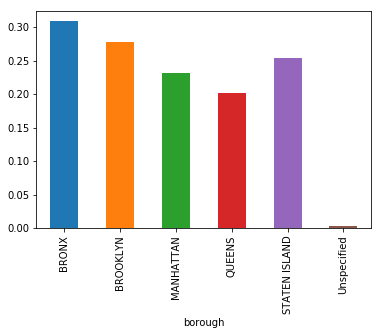

In [48]:
#How many people in each Borough

df_by_borough_zip = df.groupby(['borough','incident_zip'])
df_by_borough = df.groupby(['borough'])


population_zip_borough = df_by_borough_zip.first()

population_per_borough = population_zip_borough.groupby('borough').pop_2010.sum()

#complainers by borough

complaints_per_borough = df_by_borough.complaint_type.count()


# Complaints per person
complaints_per_person = complaints_per_borough/population_per_borough
display(complaints_per_person.to_frame())
display(complaints_per_person.plot.bar())